# Sequitur and graph metrics for speech

### metrics
- number of nodes
- number of edges
- predictability / entropy of adjacency matrix
- sequitur
- In general, a network is considered “complex” if it exhibits many features such as small diameter, high clustering coefficient, anticorrelation of node degrees, presence of network motifs, and modularity structures [8].
    - - https://www.hindawi.com/journals/complexity/2017/3250301/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten
from childes_mi.utils.general import flatten,save_fig

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [6]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [7]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [8]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

In [9]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


In [10]:
import seaborn as sns
from childes_mi.utils.general import flatten,save_fig

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Compute graph
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

#### Run MI by age cohort

In [11]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [12]:
phon_table = "https://docs.google.com/spreadsheets/d/1dcbQLKhazUePZrdgMimxZk3lbgPfZ_1VK5npFB3YJp4/edit#gid=0"

In [13]:
import requests as rs
csv_url='https://docs.google.com/spreadsheets/d/1dcbQLKhazUePZrdgMimxZk3lbgPfZ_1VK5npFB3YJp4/export?format=csv&id=1dcbQLKhazUePZrdgMimxZk3lbgPfZ_1VK5npFB3YJp4&gid=0'
res=rs.get(url=csv_url)
open('phon_labels.csv', 'wb').write(res.content)

21000

In [14]:
phon_labels = pd.read_csv("phon_labels.csv")

In [15]:
phon_labels[:3]

,Glyph,Unicode Value,Name,Type,Features
0,∅,0x2205,Empty Set,cover symbol,NaN
1,NaN,0x20,Space,space,NaN
2,$,0x24,Dollar Sign,dollar sign,NaN


In [16]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [17]:
import copy

In [18]:
import pymde
import networkx as nx
import numpy as np
import scipy.sparse as sp
import torch
from sksequitur import Parser, Grammar
from itertools import accumulate

In [19]:
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

In [20]:
import scipy

In [21]:
def make_trans_mat(utterances, n_unique_phones, unique_phones_dict):
    # create transition matrix
    trans_mat = np.zeros((n_unique_phones, n_unique_phones))
    for utterance in utterances:
        for phone_prev, phone_next in zip(
            list(utterance[:-1]), list(utterance[1:])
        ):
            trans_mat[
                unique_phones_dict[phone_prev], unique_phones_dict[phone_next]
            ] += 1
    trans_mat_no_self = copy.deepcopy(trans_mat)
    for i in range(trans_mat.shape[1]):
        trans_mat_no_self[i, i] = 0
    return trans_mat, trans_mat_no_self

In [22]:
from pomegranate import DiscreteDistribution, State, HiddenMarkovModel
def utterances_to_markov_model(utterances):
    unique_phones = np.unique([item for sublist in utterances for item in sublist])
    unique_phones_dict = {j:i+2 for i,j in enumerate(unique_phones)}
    trans_mat = np.zeros((len(unique_phones)+2, len(unique_phones)+2))
    for utterance in utterances:
        trans_mat[0, unique_phones_dict[utterance[0]]] += 1
        trans_mat[unique_phones_dict[utterance[-1]], 1] += 1
        for outgoing, incoming in zip(utterance[:-1], utterance[1:]):
            trans_mat[unique_phones_dict[outgoing], unique_phones_dict[incoming]] += 1

    trans_mat_prob = np.nan_to_num(trans_mat.T / np.sum(trans_mat, axis = 1)).T
    dists = [DiscreteDistribution({unique_phones[i]:1.0}) for i in range(len(trans_mat_prob)-2)]
    starts = trans_mat_prob[0, 2:]
    ends = trans_mat_prob[2:,1]
    trans_mat = trans_mat_prob[2:,2:]
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends)
    return model


In [23]:
import itertools

unique_phones_all = np.unique(
    np.concatenate(
        [
            np.unique(
                list(
                    "".join(
                        [
                            i
                            for i in list(itertools.chain.from_iterable(i))
                            if type(i) is str
                        ]
                    )
                )
            )
            for i in phone_df.phones.values
        ]
    )
)
print(unique_phones_all, len(unique_phones_all))

['(' ')' '*' '.' 'C' 'G' 'V' '^' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j'
 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' 'æ' 'ç'
 'ð' 'ø' 'ŋ' 'œ' 'ǁ' 'ɐ' 'ɑ' 'ɒ' 'ɔ' 'ɕ' 'ɖ' 'ə' 'ɚ' 'ɛ' 'ɜ' 'ɟ' 'ɡ' 'ɢ'
 'ɣ' 'ɥ' 'ɦ' 'ɨ' 'ɪ' 'ɫ' 'ɬ' 'ɭ' 'ɮ' 'ɯ' 'ɰ' 'ɱ' 'ɲ' 'ɳ' 'ɵ' 'ɶ' 'ɸ' 'ɹ'
 'ɻ' 'ɽ' 'ɾ' 'ʀ' 'ʁ' 'ʂ' 'ʃ' 'ʈ' 'ʉ' 'ʊ' 'ʋ' 'ʌ' 'ʍ' 'ʎ' 'ʏ' 'ʑ' 'ʒ' 'ʔ'
 'ʙ' 'ʝ' 'ʤ' 'ʦ' 'ʧ' 'ʰ' 'ʲ' 'ʴ' 'ʷ' 'ˈ' 'ˌ' 'ː' 'ˑ' '˞' 'ˠ' '˺' '́' '̂'
 '̃' '̆' '̈' '̑' '̚' '̞' '̠' '̣' '̤' '̥' '̩' '̪' '̬' '̰' '̵' '̹' '͆' '͍'
 '͡' 'β' 'θ' 'χ'] 130


In [24]:
import seaborn as sns
# get color categories
pal = {i: j for i, j in zip(phon_labels.Type.unique(), sns.color_palette("tab10", len(phon_labels.Type.unique())))}
unique_phones_color_dict = {}
for i in unique_phones_all:
    if i in phon_labels.Glyph.values:
        _type = phon_labels[phon_labels.Glyph.values == i].Type.values[0]
        unique_phones_color_dict[i] = pal[_type]
    else:
        unique_phones_color_dict[i] = (0.5,0.5,0.5)

In [34]:
def plot_graph(trans_mat, unique_phones, ax):
    
    G = nx.from_numpy_matrix(trans_mat, create_using=nx.MultiDiGraph)
    pos = nx.drawing.nx_agraph.pygraphviz_layout(G)

    node_sizes = [800 for i in range(len(G))]
    M = G.number_of_edges()
    #edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    edge_alphas = [edge[2]['weight'] for edge in G.edges(data=True)]
    node_colors = [unique_phones_color_dict[i] for i in unique_phones]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        arrowstyle="-|>",
        arrowsize=10,
        edge_color='k',
        edge_cmap=plt.cm.Greys,
        width=2,

    )
    # set alpha value for each edge
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])

    #pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
    #pc.set_array(edge_colors)
    #plt.colorbar(pc)

    for posi, label_pos in enumerate(pos):
        ax.text(
            x=pos[label_pos][0],
            y=pos[label_pos][1],
            s=unique_phones[posi],
            horizontalalignment="center",
            verticalalignment="center",
            color='white',
            fontsize=15
        )

    ax = plt.gca()
    ax.set_axis_off()

In [26]:
from sksequitur import Parser, Grammar
def get_sequitur_compression(utterances):
    # sequitur compression
    parser = Parser()
    for i in utterances:
        parser.feed(list(i))
    grammer = Grammar(parser.tree)
    sequitur_compression_length = len(grammer[0])
    sequitur_compression = len(utterances)  / sequitur_compression_length
    return sequitur_compression

In [27]:
from scipy import stats
def compute_mean_transition_entropy(utterances):
    all_phones = [item for sublist in utterances for item in sublist]
    unique_phones = np.unique(all_phones)
    n_unique_phones = len(unique_phones)
    unique_phones_dict = {i: ii for ii, i in enumerate(unique_phones)}

    # make transition matrix
    trans_mat, trans_mat_no_self = make_trans_mat(
        utterances, n_unique_phones, unique_phones_dict
    )
    trans_mat_prob = np.nan_to_num((trans_mat / np.sum(trans_mat, axis=0)))

    return np.mean(
    [
        stats.entropy(i)
        for i in trans_mat_prob.T
        if np.isnan(stats.entropy(i)) == False
    ]
    )

In [28]:
def get_metrics(utterances):
    # number of phones and unique_phones
    all_phones = [item for sublist in utterances for item in sublist]
    n_phones = len(all_phones)
    unique_phones = np.unique(all_phones)
    n_unique_phones = len(unique_phones)
    unique_phones_dict = {i: ii for ii, i in enumerate(unique_phones)}

    # make transition matrix
    trans_mat, trans_mat_no_self = make_trans_mat(
        utterances, n_unique_phones, unique_phones_dict
    )
    trans_mat_prob = np.nan_to_num((trans_mat / np.sum(trans_mat, axis=0)))

    # create a graph and get graph-based statistics
    G = nx.from_numpy_matrix(trans_mat_prob)
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
    except:
        diameter = np.nan
    clustering_coefficient = nx.average_clustering(G)

    sequitur_compression = get_sequitur_compression(utterances)

    # transition entropy
    mean_transition_entropy = np.mean(
        [
            scipy.stats.entropy(i)
            for i in trans_mat_prob.T
            if np.isnan(scipy.stats.entropy(i)) == False
        ]
    )

    return pd.DataFrame(
        [[
            n_unique_phones,
            n_phones,
            diameter,
            clustering_coefficient,
            sequitur_compression,
            mean_transition_entropy,
        ]],
        columns=[
            "n_unique_phones",
            "n_phones",
            "diameter",
            "clustering_coefficient",
            "sequitur_compression",
            "mean_transition_entropy",
        ],
    ), unique_phones, trans_mat_prob

In [29]:
from joblib import Parallel, delayed
def get_markov_compression(utterances):
    # markov model
    model = utterances_to_markov_model(utterances)
    markov_utterances = model.sample(len(utterances))
    return get_sequitur_compression(markov_utterances), compute_mean_transition_entropy(markov_utterances)

def get_random_compression(utterances):
    # markov model
    # make randomized utterance
    utterance_lengths = [len(i) for i in utterances]
    utterance_list = np.random.permutation(list("".join(utterances)))
    permuted_utterance = [
        "".join(utterance_list[x - y : x])
        for x, y in zip(accumulate(utterance_lengths), utterance_lengths)
    ]
    return get_sequitur_compression(permuted_utterance), compute_mean_transition_entropy(permuted_utterance)

0.5 1


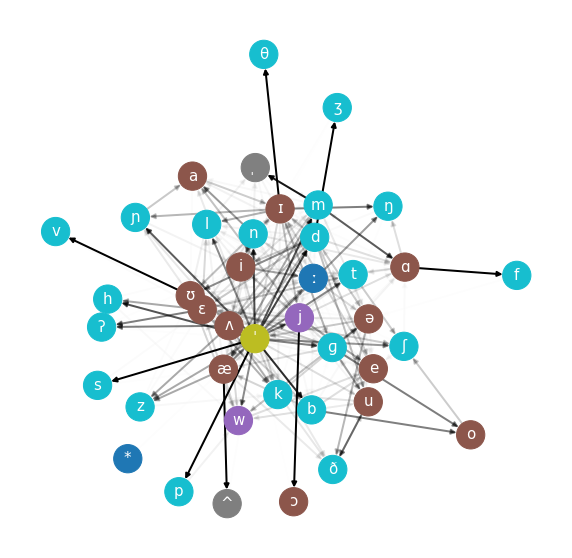

1 1.5


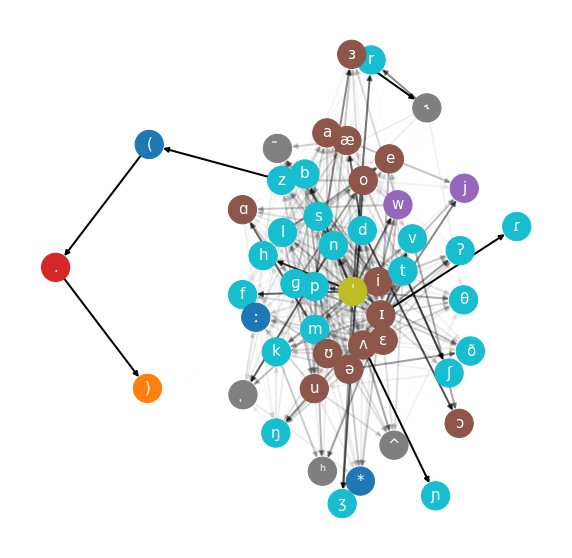

1.5 2


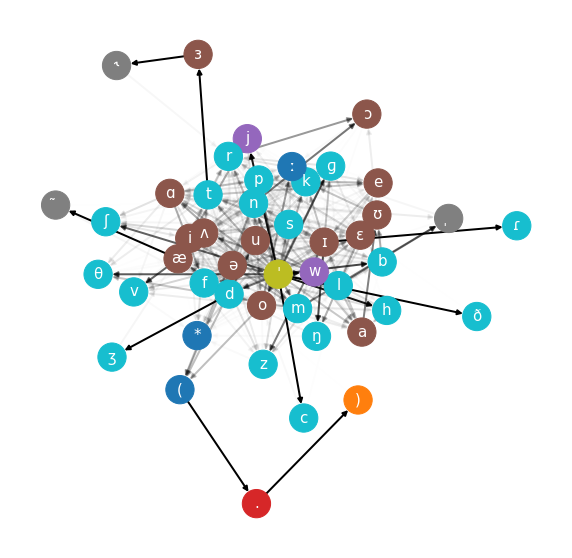

2 2.5


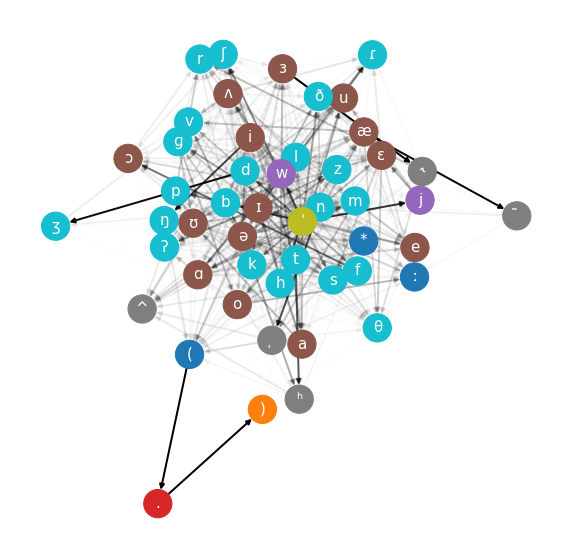

2.5 3


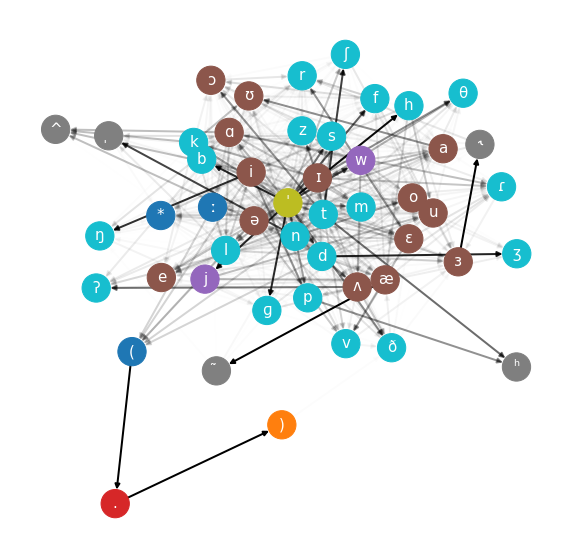

3 20


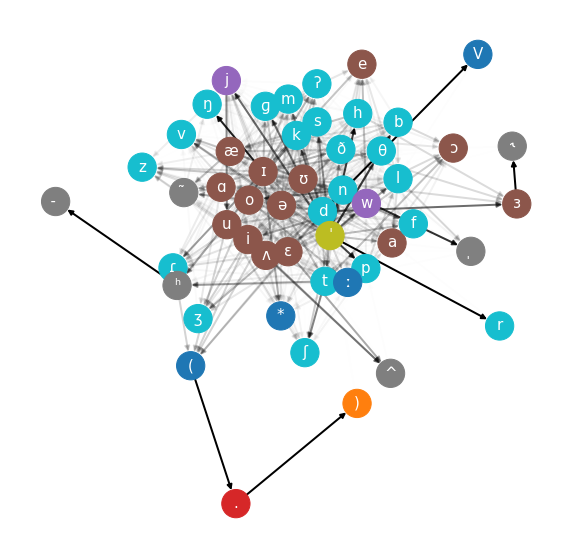

In [35]:
nex = 1
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    print(age_cohort_low, age_cohort_high)
    for idx, longest_row in tqdm(
        cohort_subset.sort_values(by="n_phones", ascending=False)[:nex].reset_index().iterrows(),
        total=nex, leave=False
    ):
        words_utterances_phones = [
            flatten(i) for i in longest_row.phones if i[0] is not None
        ]
        words_utterances_phones = [
            [j for j in i if j is not None] for i in words_utterances_phones
        ]

        utterances = ["".join(i) for i in words_utterances_phones]
        
        metrics_df_row, unique_phones, trans_mat = get_metrics(utterances)
                        
        if idx == 0:
            fig, ax = plt.subplots(figsize=(10,10))
            plot_graph(trans_mat, unique_phones, ax)
            ensure_dir(FIGURE_DIR/'sequitur')
            save_fig(FIGURE_DIR/'sequitur'/'markov_{}'.format(age_cohort_low))
            plt.show()